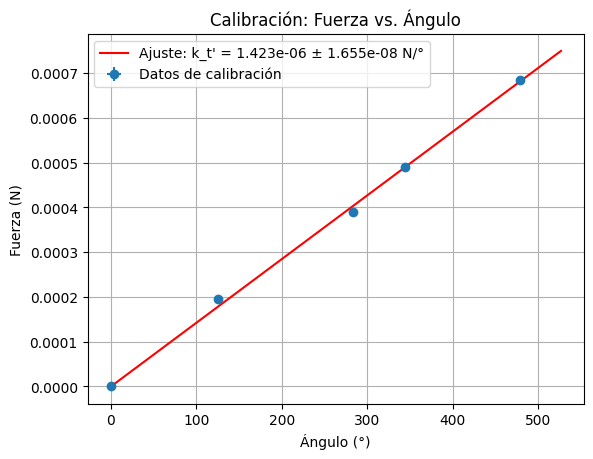

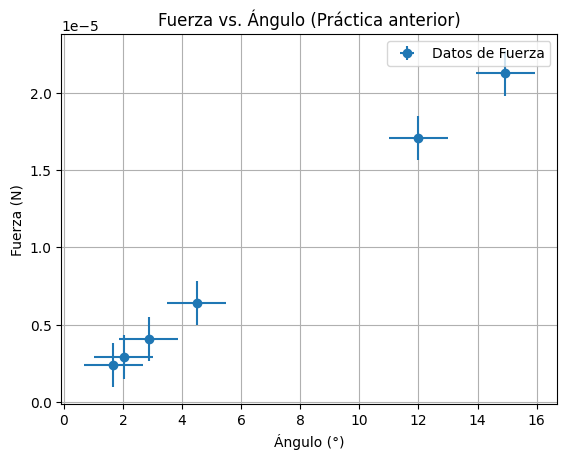

Constante de torsión (k_t') en N/°:
k_t' = 1.423e-06 ± 1.655e-08 N/°

Resultados para la práctica anterior:
Medición 1:
  Ángulo: 14.94°
  Fuerza: 2.125e-05 ± 1.444e-06 N
  Carga:  2.431e-09 ± 8.260e-11 C

Medición 2:
  Ángulo: 12.00°
  Fuerza: 1.707e-05 ± 1.437e-06 N
  Carga:  2.179e-09 ± 9.168e-11 C

Medición 3:
  Ángulo: 4.50°
  Fuerza: 6.403e-06 ± 1.425e-06 N
  Carga:  1.334e-09 ± 1.485e-10 C

Medición 4:
  Ángulo: 2.88°
  Fuerza: 4.094e-06 ± 1.424e-06 N
  Carga:  1.067e-09 ± 1.855e-10 C

Medición 5:
  Ángulo: 2.03°
  Fuerza: 2.890e-06 ± 1.423e-06 N
  Carga:  8.965e-10 ± 2.207e-10 C

Medición 6:
  Ángulo: 1.68°
  Fuerza: 2.386e-06 ± 1.423e-06 N
  Carga:  8.146e-10 ± 2.429e-10 C



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear carpeta para guardar gráficas, si no existe
os.makedirs("Graficas", exist_ok=True)

# -----------------------------
# Datos de calibración (nueva práctica)
# -----------------------------
# Vector de masa en mg (se incluye el dato (0 mg, 0°))
mass_mg = np.array([0.0, 19.9, 39.7, 49.9, 69.8])  # mg
# Vector de ángulos medidos en la calibración (en grados)
theta_deg_torsion = np.array([0.0, 125.0, 283.0, 344.0, 479.0])  # grados

# Errores asociados a la masa y al ángulo en la calibración
error_mass = 0.1         # mg
error_theta_torsion = 1  # °

g = 9.81  # Aceleración debida a la gravedad (m/s^2)

# Convertir masa de mg a kg
mass_kg = mass_mg * 1e-6

# Calcular la fuerza de calibración: F = m * g  (en N)
F_calib = mass_kg * g

# -----------------------------
# Ajuste forzado a origen: F_calib = k_t' * theta (θ en grados)
# Se realiza la regresión lineal usando los datos de calibración.
# -----------------------------
A = theta_deg_torsion.reshape(-1, 1)  # vector columna de ángulos en °

# Regresión lineal forzada por el origen
k_t_prime_arr, residuals, rank, s = np.linalg.lstsq(A, F_calib, rcond=None)
k_t_prime = k_t_prime_arr[0]  # constante de torsión en N/°

# Cálculo del error de k_t_prime usando los residuos
n = len(theta_deg_torsion)
if n > 1 and residuals.size > 0:
    variance = residuals[0] / (n - 1)
    sigma_k_t_prime = np.sqrt(variance / np.sum(theta_deg_torsion**2))
else:
    sigma_k_t_prime = np.nan

# -----------------------------
# Graficar la calibración (F_calib vs. θ en grados)
# -----------------------------
theta_fit_deg = np.linspace(0, theta_deg_torsion.max()*1.1, 100)
F_fit = k_t_prime * theta_fit_deg

plt.figure()
plt.errorbar(theta_deg_torsion, F_calib, 
             xerr=error_theta_torsion, 
             yerr=(error_mass*1e-6)*g, fmt='o', label='Datos de calibración')
plt.plot(theta_fit_deg, F_fit, 'r-', label=f'Ajuste: k_t\' = {k_t_prime:.3e} ± {sigma_k_t_prime:.3e} N/°')
plt.xlabel('Ángulo (°)')
plt.ylabel('Fuerza (N)')
plt.title('Calibración: Fuerza vs. Ángulo')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("Graficas", "regresion_torsion.png"), dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Datos de la práctica anterior para calcular Fuerza y Carga
# -----------------------------
# Vector de ángulos medidos en la práctica anterior (en grados), se incluye (0°) para la referencia
theta_deg_prev = np.array([14.9363, 11.9974, 4.5, 2.8774, 2.0315, 1.67711])  # en °
error_theta_prev = 1  # error en ° para estos ángulos

# Calcular la fuerza usando la constante de torsión: F = k_t' * θ
F_prev = k_t_prime * theta_deg_prev  # Fuerza en N

# Propagación del error en F:
# Para cada dato, si theta = 0, asignamos sigma_F = k_t_prime * error_theta_prev,
# de lo contrario, usamos la fórmula: σ_F = F * sqrt((σ_k_t'/k_t')^2 + (error_theta_prev/θ)^2)
sigma_F_prev = np.where(theta_deg_prev == 0,
                        k_t_prime * error_theta_prev,
                        F_prev * np.sqrt((sigma_k_t_prime/k_t_prime)**2 + (error_theta_prev/theta_deg_prev)**2))

# -----------------------------
# Cálculo de la carga a partir de la ley de Coulomb:
# F = k_e * q^2 / R^2  =>  q = sqrt(F * R^2 / k_e)
# -----------------------------
R = 0.05       # Distancia entre las esferas en metros
k_e = 8.99e9   # Constante de Coulomb en N·m²/C²

q = np.sqrt(F_prev * R**2 / k_e)
# Propagación del error para q: σ_q = (R² / (2 * k_e * q)) * σ_F
sigma_q = (R**2 / (2 * k_e * q)) * sigma_F_prev

# -----------------------------
# Graficar Fuerza vs. Ángulo para la práctica anterior
# -----------------------------
plt.figure()
plt.errorbar(theta_deg_prev, F_prev, xerr=error_theta_prev, yerr=sigma_F_prev, fmt='o', label='Datos de Fuerza')
plt.xlabel('Ángulo (°)')
plt.ylabel('Fuerza (N)')
plt.title('Fuerza vs. Ángulo (Práctica anterior)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join("Graficas", "fuerza_vs_angulo.png"), dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------
# Imprimir resultados
# -----------------------------
print("Constante de torsión (k_t') en N/°:")
print(f"k_t' = {k_t_prime:.3e} ± {sigma_k_t_prime:.3e} N/°\n")

print("Resultados para la práctica anterior:")
for i in range(len(theta_deg_prev)):
    print(f"Medición {i+1}:")
    print(f"  Ángulo: {theta_deg_prev[i]:.2f}°")
    print(f"  Fuerza: {F_prev[i]:.3e} ± {sigma_F_prev[i]:.3e} N")
    print(f"  Carga:  {q[i]:.3e} ± {sigma_q[i]:.3e} C\n")
